In [15]:
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
import gd1_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function

ro=8.
vo=220.

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


In [2]:
#setup the bar

#Compute normalization rho_0

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6

Mbar=10**10 #Msun, half of what Wang is using, same as Pearson


def rho1(R,z):
    return (2.*np.pi*x0*y0)*R*np.exp(-0.5*(np.sqrt(R**4 + (z/z0)**4)))

rho1norm= integrate.nquad(rho1,[[0,np.inf],[-np.inf,np.inf]])[0]

def rho2(R):
    return (z0**1.85 *4.*np.pi/q**2)*R**(0.15)*np.exp(-R/z0)

rho2norm= integrate.quad(rho2,0,np.inf)[0]
rho0=Mbar/(rho1norm + rho2norm)

def r1c(R,z,p):
    return ((R**4.)*(np.cos(p)**2./x0**2 + np.sin(p)**2/y0**2)**2 + (z/z0)**4.)**(0.25)

def r2c(R,z):
    return np.sqrt((q*R)**2. + z**2.)/z0


def rho_bar_cyl(R,z,p):
    return rho0*(np.exp((-r1c(R,z,p)**2.)/2.) + r2c(R,z)**(-1.85)*np.exp(-r2c(R,z)))


def initial_angle(pat_speed,t_age_Gyr=5.,fin_phi_deg=27.):
    
    kpc_to_km= 1000.*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
    Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
    o_p = (2.*np.pi)*(pat_speed/kpc_to_km)  #rad/s

    fin_phi= np.radians(fin_phi_deg)
    init_phi= fin_phi - o_p*(t_age_Gyr*Gyr_to_s)
    return init_phi

n=9
l=19

Acos,Asin= potential.scf_compute_coeffs(lambda R,z,p: rho_bar_cyl(R*8.,z*8.,p)/(10**9.*bovy_conversion.dens_in_msolpc3(220.,8.)),
                                        N=n+1,L=l+1,a=1./ro,radial_order=40,costheta_order=40,phi_order=40)



def MWPotentialSCFbar(mbar,Ac=Acos,As=Asin,rs=1.,normalize=False,pat_speed=35.,fin_phi=27.,t_age_Gyr=9.):
    a=rs/ro
    omegaP=pat_speed*(ro/vo)
    init_ang=initial_angle(pat_speed=pat_speed,t_age_Gyr=t_age_Gyr,fin_phi_deg=fin_phi)
    
    mrat=mbar/10.**10. #10^10 mass of bar used to compute Acos and Asin
    
    static_bar=potential.SCFPotential(amp=mrat,Acos=Ac,Asin=As,a=a,normalize=normalize)
    
    #Note only m=0 terms are considered 
    static_axi_bar=potential.SCFPotential(amp=mrat,Acos=numpy.atleast_3d(Ac[:,:,0]),a=a)
    
    barrot=potential.SolidBodyRotationWrapperPotential(pot=static_bar,omega=omegaP,ro=ro,vo=vo,pa=init_ang)
    
    if mbar <= 5.*10**9. :
        MWP2014SCFbar=[MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        #setup the corresponding axisymmetric bar
        MWP2014SCFnobar= [MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    else : 
        MWP2014SCFbar=[MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        
        MWP2014SCFnobar= [MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    return (MWP2014SCFbar,MWP2014SCFnobar)

In [3]:
Mbar=10**10.
pat_speed=35.
ang=27.
barpot=MWPotentialSCFbar(Mbar,pat_speed=pat_speed,fin_phi=ang)[0]
nobarpot=MWPotentialSCFbar(Mbar,pat_speed=pat_speed,fin_phi=ang)[1]

In [4]:
#coloring stuff

cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

In [5]:
#setup Pal 5 smooth stream, only the trailing arm at the moment, for different potentials


sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
#sdf_leading= pal5_util.setup_pal5model(pot=nobarpot,leading=True)

#Sample N points from the smooth model today 
N=300
Rt,vRt,vTt,zt,vzt,phit,dtt= sdf_trailing.sample(n=N,returndt=True)
#Rl,vRl,vTl,zl,vzl,phil,dtl= sdf_leading.sample(n=N,returndt=True)
#l,b,d,vlos,pmll,pmbb = sdf_smooth.sample(n=N,lb=True)

trackRADec_trailing=bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)

#trackRADec_leading=bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
#                          sdf_leading._interpolatedObsTrackLB[:,1],
#                          degree=True)

#add color label based on time of stripping

#stripping time bins:
t_age= 5. 
dt_bins=np.linspace(0.,t_age,6)
print (dt_bins)

lt_unp=numpy.empty(N)
bt_unp=numpy.empty(N)
dtt_s=numpy.empty(N)

ll_unp=numpy.empty(N)
bl_unp=numpy.empty(N)
dtl_s=numpy.empty(N)

for i in range(N):
    dtt_s[i]=numpy.digitize(dtt[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    lt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[0]
    bt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[1]
    
    #dtl_s[i]=numpy.digitize(dtl[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    #ll_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[0]
    #bl_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[1]
    
radec1t=bovy_coords.lb_to_radec(lt_unp,bt_unp,degree=True) 
#radec1l=bovy_coords.lb_to_radec(ll_unp,bl_unp,degree=True)

[ 0.  1.  2.  3.  4.  5.]


In [6]:
# integrate these N particles *backward* in time to when they were all stripped (they were stripped dt in the past, dt is different for each particle); something like
orbitst= []
orbitsl= []

#N=500
finalRt= numpy.empty(N)
finalphit= numpy.empty(N)
finalzt= numpy.empty(N)

finalRt1= numpy.empty(N)
finalphit1= numpy.empty(N)
finalzt1= numpy.empty(N)

finalRl= numpy.empty(N)
finalphil= numpy.empty(N)
finalzl= numpy.empty(N)

lt_p=numpy.empty(N)
bt_p=numpy.empty(N)

lt_p1=numpy.empty(N)
bt_p1=numpy.empty(N)

ll_p=numpy.empty(N)
bl_p=numpy.empty(N)


for ii in range(N):
    ot= Orbit([Rt[ii],vRt[ii],vTt[ii],zt[ii],vzt[ii],phit[ii]]).flip() # flip flips the velocities for backwards integration
    tst= numpy.linspace(0.,dtt[ii],1001)
    ot.integrate(tst,nobarpot)
    orbitst.append(ot(tst[-1]).flip()) # get the orbit at the final time step, flip the velocities for forward integration below
    
    #leading   
    #ol= Orbit([Rl[ii],vRl[ii],vTl[ii],zl[ii],vzl[ii],phil[ii]]).flip() # flip flips the velocities for backwards integration
    #tsl= numpy.linspace(0.,dtl[ii],1001)
    #ol.integrate(tsl,nobarpot)
    #orbitsl.append(ol(tsl[-1]).flip())  # get the orbit at the final time step, flip the velocities for forward integration below
        

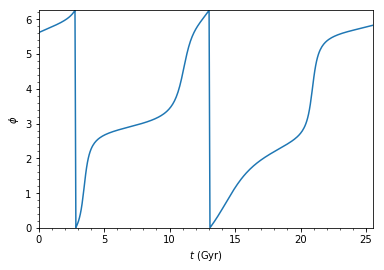

In [27]:
orbitst[1].plotphi(d1='t',ro=ro)

In [28]:
orbs=orbitst

t_bar_on_Gyr= 1.5 #Gyr in the past 
t_on=t_bar_on_Gyr/bovy_conversion.time_in_Gyr(vo,ro)


for ii in range(N):    
#forward integrate in barred potential
    tst= numpy.linspace(0.,dtt[ii],1001)
    
    orbs[ii].integrate(tst,barpot)
    
    finalRt1[ii]= orbs[ii].R(tst[-1])
    finalphit1[ii]= orbs[ii].phi(tst[-1])
    finalzt1[ii]= orbs[ii].z(tst[-1])
    
    if dtt[ii] > t_on :
        
        tbefore= tst[tst < (dtt[ii]-t_on)]
        #print (tbefore)
        orbitst[ii].integrate(tbefore,nobarpot)
        
        #initialize new orbit 
        neworbitst= orbitst[ii](tbefore[-1])
        
        nt=len(tst[tst >=(dtt[ii]-t_on)])
        tafter=numpy.linspace(0.,t_on,nt)
        #print (tafter)
        neworbitst.integrate(tafter,barpot) 
        
        finalRt[ii]= neworbitst.R(tafter[-1])
        finalphit[ii]= neworbitst.phi(tafter[-1])
        finalzt[ii]= neworbitst.z(tafter[-1])
        
         
    else :
        orbitst[ii].integrate(tst,barpot)
        finalRt[ii]= orbitst[ii].R(tst[-1])
        finalphit[ii]= orbitst[ii].phi(tst[-1])
        finalzt[ii]= orbitst[ii].z(tst[-1])
    '''    
    tsl= numpy.linspace(0.,dtl[ii],1001)
    
    if dtl[ii] > t_on :
        tbefore= tsl[tsl < (dtl[ii]-t_on)]
        orbitsl[ii].integrate(tbefore,nobarpot)
        
        #initialize new orbit 
        neworbitsl= orbitsl[ii](tbefore[-1])
        
        nl=len(tsl[tsl >=(dtl[ii]-t_on)])
        tafter=numpy.linspace(0.,t_on,nl)
        neworbitsl.integrate(tafter,barpot) 
        
        finalRl[ii]= neworbitsl.R(tafter[-1])
        finalphil[ii]= neworbitsl.phi(tafter[-1])
        finalzl[ii]= neworbitsl.z(tafter[-1])
        
         
    else :
        orbitsl[ii].integrate(tsl,barpot)
        finalRl[ii]= orbitsl[ii].R(tsl[-1])
        finalphil[ii]= orbitsl[ii].phi(tsl[-1])
        finalzl[ii]= orbitsl[ii].z(tsl[-1])
        
    '''   
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    lt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[0]
    bt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[1]
    
    #ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    #bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)  
radecpt1=bovy_coords.lb_to_radec(lt_p1,bt_p1,degree=True)  
#radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 
     
        

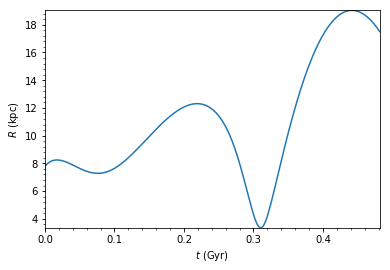

In [46]:
mxieta_t= pal5_util.radec_to_pal5xieta(radecpt[:,0],radecpt[:,1],degree=True)
xi_t= mxieta_t[:,0]

ind=[]

for ii in range(len(xi_t)):
    if 0.25 < xi_t[ii] < 14.35 :
        ind.append(ii)
        
orbitst[ind[5]].plotR(d1='t',ro=ro,vo=vo)



/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



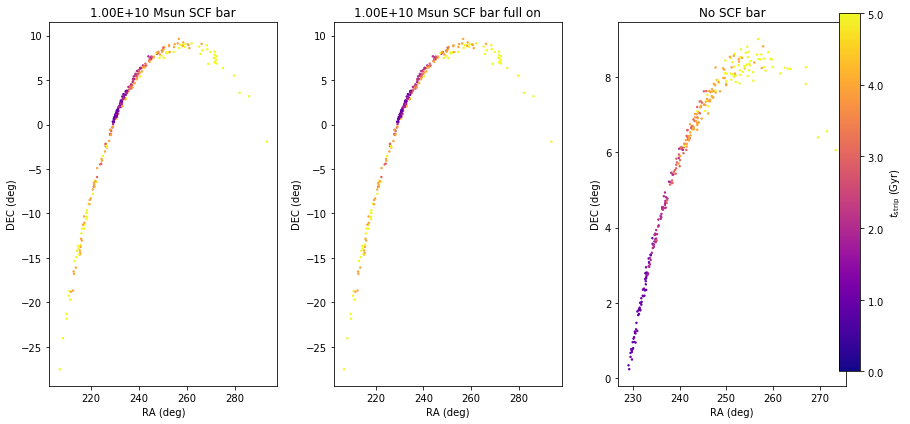

In [8]:
from decimal import Decimal

plt.figure(figsize=(12,6))
plt.subplot(1,3, 1)
plt.title('%.2E Msun SCF bar'%Decimal(Mbar))

plt.scatter(radecpt[:,0],radecpt[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

#plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')

plt.subplot(1,3, 2)
plt.title('%.2E Msun SCF bar full on'%Decimal(Mbar))

plt.scatter(radecpt1[:,0],radecpt1[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

#plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')



plt.subplot(1, 3, 3)
plt.title('No SCF bar')

plt.scatter(radec1t[:,0],radec1t[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')


#plt.scatter(radec1l[:,0],radec1l[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.legend(loc='upper left')
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
tight_layout()
#plt.savefig('plots/Pal5_Mbar10_10Msun_patspeed65_barangle27.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

In [ ]:
t_bar_on_Gyr= 1. #Gyr in the past 
t_on=t_bar_on_Gyr/bovy_conversion.time_in_Gyr(vo,ro)

dtt=2./bovy_conversion.time_in_Gyr(vo,ro)

ts= numpy.linspace(0.,dtt,1001)

orb=[1.,0.1,0.03,0.,0.1,0.] 
orb_nobar=orb.integrate(ts,nobarpot)

tbefore= ts[ts < (dtt[ii]-t_on)]
tafter=tst[tst >=(dtt[ii]-t_on)]
orb_bar=orb.integrate(ts,nobarpot)
    

Mbar=10**10.

ts= numpy.linspace(0,1.,1001)*u.Gyr
def plot_orbit_comparison(o):
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[0])
    o.plot(yrange=[-2.,2.],xrange=[0.,9.],gcf=True,c='r')
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[1])
    o.plot(overplot=True,gcf=True)
    return None

def plot_orbit_comparisonXY(o):
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[0])
    o.plot(d1='x',d2='y',xrange=[-10.,10.],yrange=[-10.,10.],gcf=True,c='r')
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[1])
    o.plot(d1='x',d2='y',overplot=True,gcf=True)
    return None


#vxvv=[R,vR,vT,z,vz,phi]

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
tight_layout()  

    
    

In [ ]:
for ii in range(N):    
#forward integrate in barred potential
    tst= numpy.linspace(0.,dtt[ii],1001)
    t_before = tst[]
    orbitst[ii].integrate(tst,barpot)
    finalRt[ii]= orbitst[ii].R(tst[-1])
    finalphit[ii]= orbitst[ii].phi(tst[-1])
    finalzt[ii]= orbitst[ii].z(tst[-1])
       
    #leading
    orbitsl[ii].integrate(tsl,barpot)
    finalRl[ii]= orbitsl[ii].R(tsl[-1])
    finalphil[ii]= orbitsl[ii].phi(tsl[-1])
    finalzl[ii]= orbitsl[ii].z(tsl[-1])
    
    
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)   
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 